In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
!gdown https://drive.google.com/drive/folders/19JWGJib5Y3PixVbsAf-EpYZZkkFvU6DC?usp=sharing

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://drive.google.com/drive/folders/19JWGJib5Y3PixVbsAf-EpYZZkkFvU6DC?usp=sharing
To: /content/drive/MyDrive/Colab Notebooks/Comp432Project/Dataset1/ColorectalCancer_/19JWGJib5Y3PixVbsAf-EpYZZkkFvU6DC?usp=sharing
1.64kB [00:00, 3.80MB/s]


In [93]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Comp432Project/Dataset1/ColorectalCancer_")#100
#os.chdir("/content/drive/My Drive/Colab Notebooks/500 Data/Colorectal Cancer") #500

In [94]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim
from torchvision import datasets, transforms

import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#print(torch.cuda.is_available())

#torch.cuda.empty_cache()

In [95]:
def get_data():
    data_dir = '/content/drive/My Drive/Colab Notebooks/Comp432Project/Dataset1/ColorectalCancer_' #100
    #data_dir = '/content/drive/My Drive/Colab Notebooks/500 Data/Colorectal Cancer' #500
    transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((64,64))])
    data_set = datasets.ImageFolder(root=data_dir, transform=transform)
    print(data_set.classes)

    n = len(data_set)  # total number of examples
    n_test = int(0.20 * n)  # take ~20% for test
    for x in range(0, 9):  # rounding it to be divisible by 4
        n_test += 1
        if n_test % 4 == 0:
            break
    train_set, test_set = torch.utils.data.random_split(data_set, [n - n_test, n_test])

    train = DataLoader(train_set, batch_size=25, shuffle=True)
    test = DataLoader(test_set, batch_size= 100, shuffle=False)


    return train, test

In [96]:

# Defining the Model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer (conv1)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer (conv2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (if needed)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)

        return out


#
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



In [97]:
# Getting the data
train, test= get_data()
# Instanciating the ResNet18 Class created earlier and Assigning it as our model
model = ResNet18(3)

# The loss function
criterion = nn.CrossEntropyLoss()
#
optimizer = optim.Adam(model.parameters(), lr=0.001)
# momentum=0.9

# Using Cuda cores for the training
#model=model.cuda()


['MUS', 'NORM', 'STR']


In [84]:
# Training
num_epoch=10
lr=0.01
test_size=0


train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

print("train")
for epoch in range(num_epoch):
    model.train()
    loss_train= 0.0
    correct = 0
    total = 0
    test_size=0


    for inputs, labels in train:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss_train = criterion(outputs, labels)
      loss_train.backward()
      optimizer.step()

      #Loss by input Train
      loss_train += loss_train.item()
      loss_by_input=loss_train / len(train)
      print(f"Epoch {epoch+1}/{num_epoch}, Loss: {loss_by_input}")

      #Accuracy
      total += labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()

    #Loss by batch Train
    loss_by_epoch=loss_train / len(train)
    train_losses.append(loss_by_epoch.detach().numpy())

    #Accuracy by batch Train
    accuracy = correct / total
    train_accuracy.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epoch}, Accuracy: {accuracy}")

    #Test
    model.eval()
    loss_test = 0.0
    correct2 = 0
    total2 = 0

    with torch.no_grad():
      for inputs, labels in test:
        outputs = model(inputs)

        test_size+=1

        #Loss Test
        loss_test = criterion(outputs, labels)
        loss_test += loss_test.item()

        #Accuracy Test
        total2 += labels.size(0)
        _, predicted2 = torch.max(outputs.data, 1)
        correct2 += (predicted2 == labels).sum().item()

      loss_by_epoch2=loss_test / len(test)
      test_losses.append(loss_by_epoch2.detach().numpy())

      accuracy2 = correct2 / total2
      test_accuracy.append(accuracy2)
      print(test_size)

    print("Test end")

print(num_epoch)
print(len(train_losses))
print(len(test_losses))


#Save model
#'/content/drive/My Drive/Colab Notebooks/Saved models/Latest save'
model_name_to_save = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Saved models/Latest save/{model_name_to_save}"
torch.save(model.state_dict(), save_dir)
print('saved')

#del model
#torch.cuda.empty_cache()

# Plot Loss Train
plt.plot(range(1, num_epoch+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss By Epoch')
plt.legend()
plt.show()


# Plot Accuracy Train
plt.plot(range(1, num_epoch+1), train_accuracy , label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy By Epoch')
plt.legend()
plt.show()

# Plot Loss Test
plt.plot(range(1, num_epoch+1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')
plt.title('Testing Loss By Epoch')
plt.legend()
plt.show()

# Plot Accuracy Test
plt.plot(range(1, num_epoch+1), test_accuracy , label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy By Epoch')
plt.legend()
plt.show()




train
Epoch 1/2, Loss: 0.0563463531434536
Epoch 1/2, Loss: 0.05588017776608467
Epoch 1/2, Loss: 0.16712850332260132
Epoch 1/2, Loss: 0.10553207248449326
Epoch 1/2, Loss: 0.05566095560789108
Epoch 1/2, Loss: 0.04785093665122986
Epoch 1/2, Loss: 0.06447543203830719
Epoch 1/2, Loss: 0.03244854137301445
Epoch 1/2, Loss: 0.04696877673268318
Epoch 1/2, Loss: 0.04014550521969795
Epoch 1/2, Loss: 0.0436277836561203
Epoch 1/2, Loss: 0.04681222513318062
Epoch 1/2, Loss: 0.05207877978682518
Epoch 1/2, Loss: 0.03646761178970337
Epoch 1/2, Loss: 0.03730625659227371
Epoch 1/2, Loss: 0.053393520414829254
Epoch 1/2, Loss: 0.029560744762420654
Epoch 1/2, Loss: 0.058434851467609406
Epoch 1/2, Loss: 0.028726719319820404
Epoch 1/2, Loss: 0.03588268160820007
Epoch 1/2, Loss: 0.031891949474811554
Epoch 1/2, Loss: 0.04124961048364639
Epoch 1/2, Loss: 0.03255579620599747
Epoch 1/2, Loss: 0.030671432614326477
Epoch 1/2, Loss: 0.0358416847884655
Epoch 1/2, Loss: 0.03710728511214256
Epoch 1/2, Loss: 0.0310501139

KeyboardInterrupt: ignored

Test
end


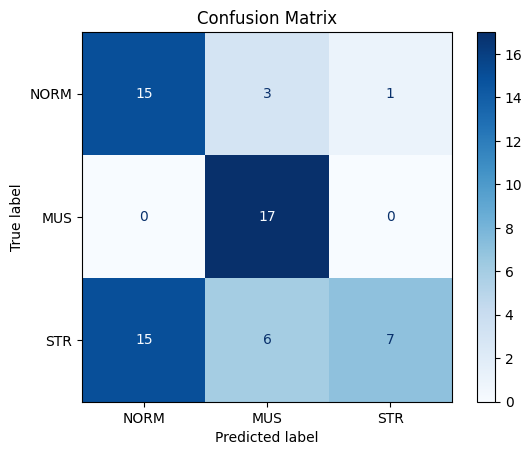

In [58]:
#Test
#Load model
model_name_to_load = model_name_to_save
save_dir=F"/content/drive/My Drive/Colab Notebooks/Saved models/Latest save/{model_name_to_load}"
model.load_state_dict(model.state_dict(), save_dir)

print('Test')
labels_array = []
predictions = []

model.eval()

with torch.no_grad():
  for inputs, labels in test:
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    labels_array.extend(labels.cpu().numpy())
    predictions.extend(predicted.cpu().numpy())

    #labels.extend(labels.cuda().numpy())
    #predictions.extend(predicted.cuda().numpy())
print("end")

# Confusion matrix
c_matrix = confusion_matrix(labels_array, predictions, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(c_matrix, display_labels=['NORM', 'MUS', 'STR'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()
